### Kalshi markets analysis
We use this jupyter notebook to analyze the data we pulled from the Kalshi API.

In [2]:
import pandas as pd
import json

In [3]:
df = pd.read_json("chosen_markets.json")
df.head()

,yes_ask,yes_bid,price,result,close_time,event_ticker,series_ticker,time_until,ticker,category,volume,timestamp
0,17,11,14.0,no,2025-09-19 17:09:26.083997+00:00,KXKLARSTRIP-40,KXKLARSTRIP,719,KXKLARSTRIP-40-STRI,Financials,658,2025-08-20 18:00:00+00:00
1,17,11,14.0,no,2025-09-19 17:09:26.083997+00:00,KXKLARSTRIP-40,KXKLARSTRIP,718,KXKLARSTRIP-40-STRI,Financials,658,2025-08-20 19:00:00+00:00
2,17,11,14.0,no,2025-09-19 17:09:26.083997+00:00,KXKLARSTRIP-40,KXKLARSTRIP,717,KXKLARSTRIP-40-STRI,Financials,658,2025-08-20 20:00:00+00:00
3,17,11,14.0,no,2025-09-19 17:09:26.083997+00:00,KXKLARSTRIP-40,KXKLARSTRIP,716,KXKLARSTRIP-40-STRI,Financials,658,2025-08-20 21:00:00+00:00
4,17,11,14.0,no,2025-09-19 17:09:26.083997+00:00,KXKLARSTRIP-40,KXKLARSTRIP,715,KXKLARSTRIP-40-STRI,Financials,658,2025-08-20 22:00:00+00:00


In [4]:
len(df.groupby('ticker')['ticker'])

8199

In [44]:
volume_cutoff = df.groupby('ticker')['volume'].first().quantile(0.25)
liquid_tickers = (
    df.groupby('ticker')['volume']
    .first()
    .loc[lambda x: x >= volume_cutoff]
    .index
)

df = df[df['ticker'].isin(liquid_tickers)]


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 664108 entries, 0 to 698379
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   yes_ask        664108 non-null  int64              
 1   yes_bid        664108 non-null  int64              
 2   price          664108 non-null  float64            
 3   result         664108 non-null  object             
 4   close_time     664108 non-null  datetime64[ns, UTC]
 5   event_ticker   664108 non-null  object             
 6   series_ticker  664108 non-null  object             
 7   time_until     664108 non-null  int64              
 8   ticker         664108 non-null  object             
 9   category       664108 non-null  object             
 10  volume         664108 non-null  int64              
 11  timestamp      664108 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), float64(1), int64(4), object(5)
memory usage: 65.9+ MB


In [46]:
df.drop(df[df['result'] == ""].index, inplace=True)

/var/folders/4r/f7k5gh050q3_v7khjwbtg6mr0000gn/T/ipykernel_33792/2649731431.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[df['result'] == ""].index, inplace=True)


In [59]:
len(df.groupby('ticker')['ticker'].count())

6121

In [47]:
def is_informative(prices, result, c):
    """Determine if the prices are consistently informative."""
    if result == "yes":
        return (prices >= c).all()
    else:
        return (prices <= (1-c)).all()

In [48]:
results = []
snapshots = [30*24, 14*24, 7*24, 3*24, 24, 12, 1]


for ticker, df_t in df.groupby("ticker"):
    df_t = df_t.sort_values("time_until")

    result = df_t['result'].iloc[0]
    category = df_t['category'].iloc[0]
    volume = df_t['volume'].iloc[0]

    for snap in snapshots:
        # take all data after this snapshot
        mask = df_t['time_until'] <= snap
        future_prices = df_t.loc[mask, 'price']/100

        informative = is_informative(future_prices, result, c=0.55)

        results.append({
            "ticker": ticker,
            "snapshot": snap,
            "informative": informative,
            "result": result,
            "category": category,
            "volume": volume
        })

In [49]:
df_results = pd.DataFrame(results)
df_results.head()

,ticker,snapshot,informative,result,category,volume
0,AVENGERSDELAY-26MAY01,720,False,yes,Entertainment,13390
1,AVENGERSDELAY-26MAY01,336,False,yes,Entertainment,13390
2,AVENGERSDELAY-26MAY01,168,False,yes,Entertainment,13390
3,AVENGERSDELAY-26MAY01,72,False,yes,Entertainment,13390
4,AVENGERSDELAY-26MAY01,24,False,yes,Entertainment,13390


In [50]:
def drop_after_first_yes(group):
    # Create a mask: True for the first 'yes' and everything before it
    # We use cumsum on the boolean column. 
    # The first 'yes' makes the sum 1. Everything after makes it > 1.
    mask = (group['informative'] == 'yes').shift(1).fillna(0).cumsum() == 0
    return group[mask]

# Application
df_cleaned = df_results.groupby('ticker', group_keys=False).apply(drop_after_first_yes)

/var/folders/4r/f7k5gh050q3_v7khjwbtg6mr0000gn/T/ipykernel_33792/1428516348.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cleaned = df_results.groupby('ticker', group_keys=False).apply(drop_after_first_yes)


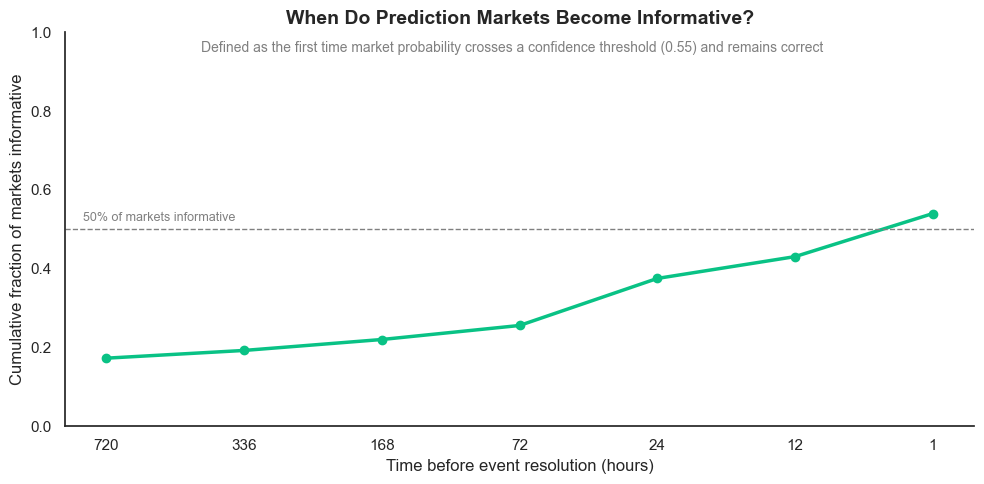

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Prepare data ---
total_tickers = df_cleaned['ticker'].nunique()

first_informative = (
    df_cleaned[df_cleaned['informative'] == True]
    .sort_values('snapshot', ascending=False)
    .groupby('ticker', as_index=False)
    .first()
)


snapshot_counts = (
    first_informative
    .groupby('snapshot')
    .size()
    .reset_index(name='count')
)


snapshot_counts['fraction'] = snapshot_counts['count'] / total_tickers

snapshot_counts['fraction'] = snapshot_counts['count'] / total_tickers

snapshot_counts = snapshot_counts.sort_values('snapshot', ascending=False)
snapshot_counts['cumulative_fraction'] = snapshot_counts['fraction'].cumsum()


# Use snapshot as categorical (clean spacing)
x_labels = snapshot_counts['snapshot'].astype(str)

# --- Plot ---
sns.set_theme(style="white")

plt.figure(figsize=(10, 5))

plt.plot(
    x_labels,
    snapshot_counts['cumulative_fraction'],
    marker="o",
    linewidth=2.5,
    color="#09C285"
)

# 50% reference line
plt.axhline(
    0.5,
    linestyle="--",
    linewidth=1,
    color="gray"
)

# Annotate the 50% line
plt.text(
    0.02,
    0.52,
    "50% of markets informative",
    transform=plt.gca().transAxes,
    fontsize=9,
    color="gray"
)

# Axis labels
plt.xlabel("Time before event resolution (hours)")
plt.ylabel("Cumulative fraction of markets informative")
plt.ylim(0, 1)

# Title
plt.title(
    "When Do Prediction Markets Become Informative?",
    fontsize=14,
    weight="bold"
)

# Subtitle
plt.text(
    0.15,
    0.95,
    "Defined as the first time market probability crosses a confidence threshold (0.55) and remains correct",
    transform=plt.gca().transAxes,
    fontsize=10,
    color="gray"
)

# Clean layout
sns.despine()
plt.tight_layout()
plt.savefig("figures/informative_markets_timing.png", dpi=300)
plt.show()


In [72]:
# First informative snapshot per ticker
first_informative = (
    df_results[df_results['informative'] == True]
    .sort_values('snapshot', ascending=False)
    .groupby('ticker', as_index=False)
    .first()
)

# Keep relevant columns
first_informative = first_informative[
    ['ticker', 'snapshot', 'category', 'result', 'volume']
]

category_summary = (
    first_informative
    .groupby('category')
    .agg(
        median_snapshot=('snapshot', 'median'),
        count=('ticker', 'count')
    )
    .reset_index()
)

# Optional: only keep categories with enough markets
category_summary = category_summary[category_summary['count'] >= 50]

In [73]:
category_summary

,category,median_snapshot,count
0,Climate and Weather,12.0,184
1,Companies,24.0,67
2,Crypto,720.0,553
5,Elections,336.0,53
6,Entertainment,72.0,451
7,Financials,720.0,67
9,Mentions,12.0,80
10,Politics,336.0,281
13,Sports,24.0,1482


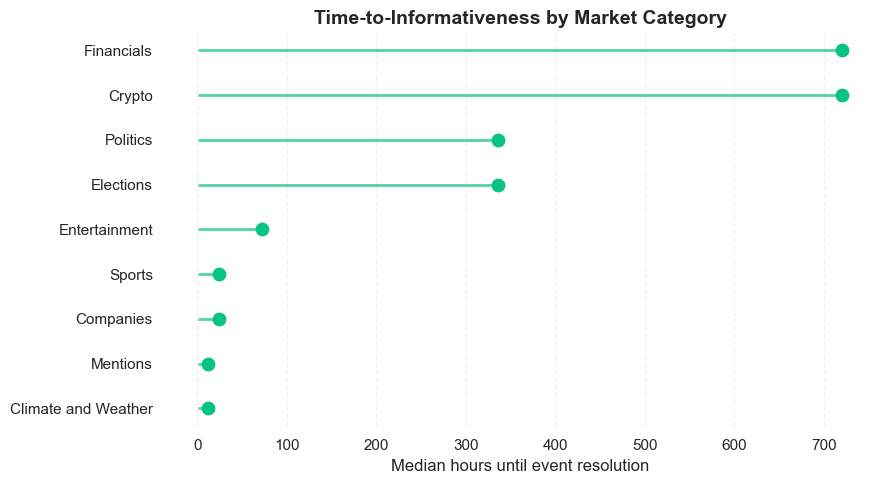

In [79]:
sns.set_theme(style="white")

# Sort categories
plot_df = category_summary.sort_values("median_snapshot")

plt.figure(figsize=(9, 5))

# Lines
plt.hlines(
    y=plot_df["category"],
    xmin=1,
    xmax=plot_df["median_snapshot"],
    color="#09C285",
    linewidth=2,
    alpha=0.7
)

# Dots
plt.scatter(
    plot_df["median_snapshot"],
    plot_df["category"],
    color="#09C285",
    s=80,
    zorder=3
)

# Labels
plt.xlabel("Median hours until event resolution")
plt.ylabel("")
plt.title(
    "Time-to-Informativeness by Market Category",
    fontsize=14,
    weight="bold"
)

# Minor grid for x-axis only
plt.grid(axis="x", which="both", linestyle="--", alpha=0.3)
plt.grid(axis="y", visible=False)

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig("figures/informative_markets_by_category.png", dpi=300)
plt.show()


In [55]:
total_by_result = (
    df_results
    .groupby('result')['ticker']
    .nunique()
    .reset_index(name='total_markets')
)

informative_by_result = (
    first_informative
    .groupby('result')['ticker']
    .nunique()
    .reset_index(name='informative_markets')
)

result_summary = total_by_result.merge(
    informative_by_result,
    on='result',
    how='left'
)

result_summary['informative_markets'] = result_summary['informative_markets'].fillna(0)
result_summary['fraction_informative'] = (
    result_summary['informative_markets'] / result_summary['total_markets']
)

/var/folders/4r/f7k5gh050q3_v7khjwbtg6mr0000gn/T/ipykernel_33792/302365359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


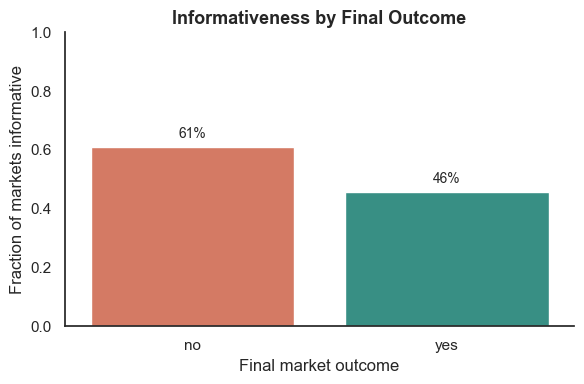

In [61]:
plt.figure(figsize=(6, 4))

sns.barplot(
    data=result_summary,
    x='result',
    y='fraction_informative',
    palette=["#E76F51","#2A9D8F"]
)

plt.ylim(0, 1)
plt.xlabel("Final market outcome")
plt.ylabel("Fraction of markets informative")
plt.title(
    "Informativeness by Final Outcome",
    fontsize=13,
    weight="bold"
)

# Annotate bars
for i, row in result_summary.iterrows():
    plt.text(
        i,
        row['fraction_informative'] + 0.03,
        f"{row['fraction_informative']:.0%}",
        ha="center",
        fontsize=10
    )

sns.despine()
plt.tight_layout()
plt.savefig("figures/informative_markets_by_result.png", dpi=300)
plt.show()


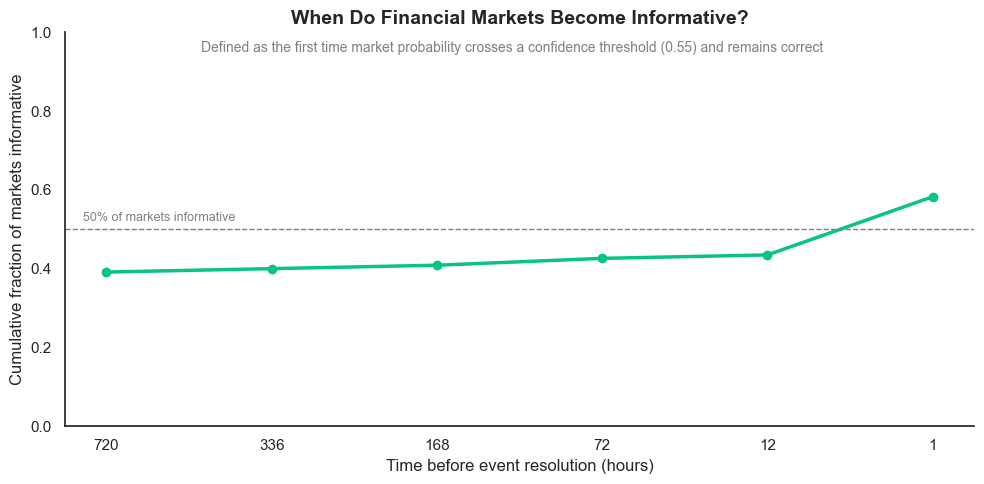

In [98]:
# --- Prepare data ---
total_tickers = df_cleaned[df_cleaned['category'] == "Financials"]['ticker'].nunique()

first_informative = (
    df_cleaned[(df_cleaned['informative'] == True) & (df_cleaned['category'] == "Financials")]
    .sort_values('snapshot', ascending=False)
    .groupby('ticker', as_index=False)
    .first()
)


snapshot_counts = (
    first_informative
    .groupby('snapshot')
    .size()
    .reset_index(name='count')
)


snapshot_counts['fraction'] = snapshot_counts['count'] / total_tickers

snapshot_counts['fraction'] = snapshot_counts['count'] / total_tickers

snapshot_counts = snapshot_counts.sort_values('snapshot', ascending=False)
snapshot_counts['cumulative_fraction'] = snapshot_counts['fraction'].cumsum()


# Use snapshot as categorical (clean spacing)
x_labels = snapshot_counts['snapshot'].astype(str)

# --- Plot ---
sns.set_theme(style="white")

plt.figure(figsize=(10, 5))

plt.plot(
    x_labels,
    snapshot_counts['cumulative_fraction'],
    marker="o",
    linewidth=2.5,
    color="#09C285"
)

# 50% reference line
plt.axhline(
    0.5,
    linestyle="--",
    linewidth=1,
    color="gray"
)

# Annotate the 50% line
plt.text(
    0.02,
    0.52,
    "50% of markets informative",
    transform=plt.gca().transAxes,
    fontsize=9,
    color="gray"
)

# Axis labels
plt.xlabel("Time before event resolution (hours)")
plt.ylabel("Cumulative fraction of markets informative")
plt.ylim(0, 1)

# Title
plt.title(
    "When Do Financial Markets Become Informative?",
    fontsize=14,
    weight="bold"
)

# Subtitle
plt.text(
    0.15,
    0.95,
    "Defined as the first time market probability crosses a confidence threshold (0.55) and remains correct",
    transform=plt.gca().transAxes,
    fontsize=10,
    color="gray"
)

# Clean layout
sns.despine()
plt.tight_layout()
plt.savefig("figures/financials_markets_timing.png", dpi=300)
plt.show()

In [96]:
# --- Prepare data ---
total_tickers = df_cleaned[df_cleaned['category'] == "Climate and Weather"]['ticker'].nunique()

first_informative = (
    df_cleaned[(df_cleaned['informative'] == True) & (df_cleaned['category'] == "Climate and Weather")]
    .sort_values('snapshot', ascending=False)
    .groupby('ticker', as_index=False)
    .first()
)


snapshot_counts = (
    first_informative
    .groupby('snapshot')
    .size()
    .reset_index(name='count')
)


snapshot_counts['fraction'] = snapshot_counts['count'] / total_tickers

snapshot_counts['fraction'] = snapshot_counts['count'] / total_tickers

snapshot_counts = snapshot_counts.sort_values('snapshot', ascending=False)
snapshot_counts['cumulative_fraction'] = snapshot_counts['fraction'].cumsum()


# Use snapshot as categorical (clean spacing)
x_labels = snapshot_counts['snapshot'].astype(str)

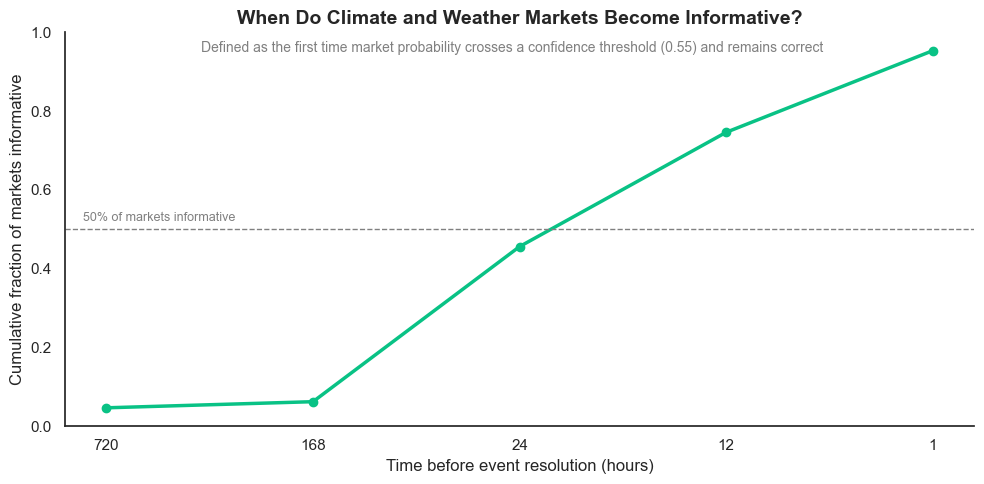

In [97]:
# --- Plot ---
sns.set_theme(style="white")

plt.figure(figsize=(10, 5))

plt.plot(
    x_labels,
    snapshot_counts['cumulative_fraction'],
    marker="o",
    linewidth=2.5,
    color="#09C285"
)

# 50% reference line
plt.axhline(
    0.5,
    linestyle="--",
    linewidth=1,
    color="gray"
)

# Annotate the 50% line
plt.text(
    0.02,
    0.52,
    "50% of markets informative",
    transform=plt.gca().transAxes,
    fontsize=9,
    color="gray"
)

# Axis labels
plt.xlabel("Time before event resolution (hours)")
plt.ylabel("Cumulative fraction of markets informative")
plt.ylim(0, 1)

# Title
plt.title(
    "When Do Climate and Weather Markets Become Informative?",
    fontsize=14,
    weight="bold"
)

# Subtitle
plt.text(
    0.15,
    0.95,
    "Defined as the first time market probability crosses a confidence threshold (0.55) and remains correct",
    transform=plt.gca().transAxes,
    fontsize=10,
    color="gray"
)

# Clean layout
sns.despine()
plt.tight_layout()
plt.savefig("figures/climate_and_weather_markets_timing.png", dpi=300)
plt.show()